# Análise dos projetos de um mesmo proponente
---

**Objetivo:** realizar uma análise comparativa entre o número de projetos culturais pertencentes a um proponente específico com o número de projetos culturais de outros proponentes. Nesta análise, será investigado se o número de projetos de um proponente é anormal com relação a outros proponentes.


Neste caso foram considerados apenas projetos em que comprovaram pelo menos um item.

#### Importando módulos necessários

In [1]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [2]:
df = pd.read_csv('../../data/raw/planilha_comprovacao.csv')
print(df.columns)
df.head()

Index(['PRONAC', 'idPlanilhaAprovacao', 'idComprovantePagamento', 'IdPRONAC',
       'idSegmento', 'cdProduto', 'cdEtapa', 'cdUF', 'UF', 'cdCidade',
       'idPlanilhaItem', 'Item', 'DataProjeto', 'nrComprovante', 'nrSerie',
       'nrCNPJCPF', 'nmFornecedor', 'proponenteCgcCpf', 'tpDocumento',
       'dtPagamento', 'dtEmissao', 'tpFormaDePagamento',
       'nrDocumentoDePagamento', 'idArquivo', 'dsJustificativaProponente',
       'dsOcorrenciaDoTecnico', 'stItemAvaliado', 'stAvaliacao',
       'vlComprovacao'],
      dtype='object')


/Users/alexandretk/.venv/new_ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,PRONAC,idPlanilhaAprovacao,idComprovantePagamento,IdPRONAC,idSegmento,cdProduto,cdEtapa,cdUF,UF,cdCidade,...,dtPagamento,dtEmissao,tpFormaDePagamento,nrDocumentoDePagamento,idArquivo,dsJustificativaProponente,dsOcorrenciaDoTecnico,stItemAvaliado,stAvaliacao,vlComprovacao
0,1012121,18552,4326,132451,71,1,1,35,SP,355030,...,2014-01-16 00:00:00,2013-03-27 00:00:00,Transferencia Bancaria,42501,410880,Elaboração de projeto gráfico do livro.,NaN,4,Aguardando analise,12000.0
1,1012121,18553,4332,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2012-04-30 00:00:00,Transferencia Bancaria,2945,410935,Reportagem e produção de textos para livro.,NaN,4,Aguardando analise,6000.0
2,1012121,18554,4755,132451,71,1,2,35,SP,355030,...,2014-01-28 00:00:00,2012-03-16 00:00:00,Transferencia Bancaria,31601,420731,Fotografia artística para o livro.,NaN,4,Aguardando analise,12000.0
3,1012121,18555,4334,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2013-08-27 00:00:00,Transferencia Bancaria,90201,410939,Tratamento de imagens para o livro.,NaN,4,Aguardando analise,6000.0
4,1012121,18556,4327,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2012-05-04 00:00:00,Transferencia Bancaria,2945,410917,Edição dos textos do livro.,NaN,4,Aguardando analise,8000.0


#### Gerando tabela com o número projetos por proponente

In [3]:
proponent_projects = df[['PRONAC', 'proponenteCgcCpf']]
proponent_projects = proponent_projects.groupby(['proponenteCgcCpf']).nunique()['PRONAC']
proponent_projects.head()

proponenteCgcCpf
3437140      1
29239630     1
56289030     1
234030631    1
387410910    1
Name: PRONAC, dtype: int64

In [4]:
proponent_projects[234030631]

1

#### Gerando gráfico dos dados acima

Média da distribuição: 1.50
Desvio padrão da distribuição: 1.04



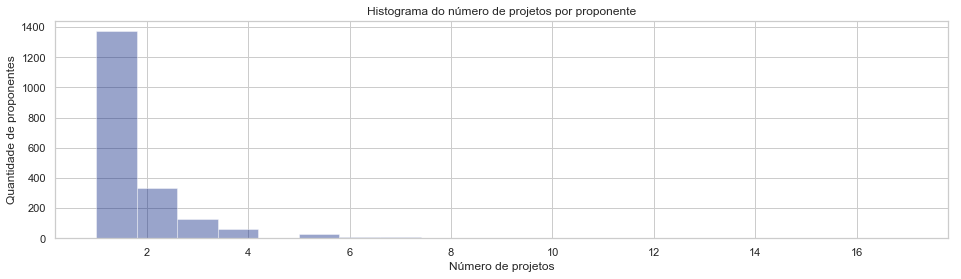

In [5]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

sns.distplot(proponent_projects, bins=20, kde=False)
plt.title('Histograma do número de projetos por proponente')
plt.ylabel('Quantidade de proponentes')
plt.xlabel('Número de projetos')
plt.grid(True)

expected_mean = np.mean(proponent_projects)
expected_std = np.std(proponent_projects)
print('Média da distribuição: %.2lf' % expected_mean)
print('Desvio padrão da distribuição: %.2lf\n' % expected_std)

#### Separando os conjuntos de treino e teste

In [6]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(proponent_projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

proponenteCgcCpf
28283478850       1
769923496         1
18553002000173    2
13311763000103    2
18189929000176    1
Name: PRONAC, dtype: int64

proponenteCgcCpf
6327965610        1
10915408000147    3
59829915972       1
3570518000159     1
13068668000112    1
Name: PRONAC, dtype: int64

### Análise Gaussiana

In [7]:
class Gaussian:
    def __init__(self, contamination=0.1):
        '''Outlier Detection by fitting data in a Gaussian model.

        Fit a Gaussian function on the training set and find the lower and upper
        limits for a sample to be considered an inlier. The limits are computed
        by translating the contamination value into a point in the Gaussian model.
        
        If the sample is farther from the average than the limits, it's considered
        an outlier. Otherwise it's an inlier.

        Parameters
        ----------
        contamination : float in (0., 0.5), optional (default=0.1)
            The amount of contamination of the data set, i.e. the proportion
            of outliers in the data set. When fitting this is used to define the
            threshold on the decision function.
        '''
        self.contamination = contamination

    def fit(self, X):
        '''Fit the Gaussian model, i.e. compute mean and standard deviation of X,
        using X as training data.

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            Training data.

        Returns
        -------
        self : object
        '''
        mean, std = scipy.stats.norm.fit(X)
        self.model = scipy.stats.norm(mean, std)
        return self
    
    def predict(self, X):
        '''Predict the labels (True inlier, False outlier) of X according to Gaussian.

        This method allows to generalize prediction to *new observations* (not
        in the training set).

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            The query sample or samples to compute the Gaussian Estimation
            w.r.t. to the training samples.

        Returns
        -------
        is_inlier : array, shape (n_samples,)
            Returns False for anomalies/outliers and True for inliers.
        '''
        lower = self.model.ppf(0.5*self.contamination)
        upper = self.model.ppf(1 - 0.5*self.contamination)
        is_inlier = ((X >= lower) & (X <= upper))
        return is_inlier

CPU times: user 1.31 ms, sys: 175 µs, total: 1.49 ms
Wall time: 1.33 ms
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 5.85%


3

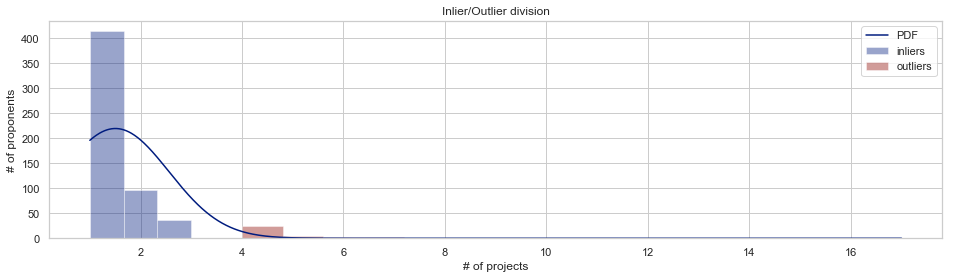

In [8]:
model = Gaussian()
model.fit(projects_train)
%time inlier_filter = model.predict(projects_test)

contamination_found = sum(~inlier_filter) / len(projects_test)
print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 1
inliers = projects_test[inlier_filter].values
bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
display(bins)
sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

outliers = projects_test[~inlier_filter].values
bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)

x = np.linspace(min(proponent_projects), max(proponent_projects), 1000)
plt.plot(x,  bin_size * len(projects_test) * model.model.pdf(x), label='PDF')

plt.legend(frameon=True)
plt.ylabel('# of proponents')
plt.xlabel('# of projects')
plt.title('Inlier/Outlier division');

### Análise Log-normal

In [9]:
class Lognormal:
    def __init__(self, contamination=0.1):
        '''Outlier Detection by fitting data in a Log-normal model.

        Fit a Log-normal function on the training set and find the upper limit for
        a sample to be considered an inlier. The limit is computed by translating
        the contamination value into a point in the Log-normal model.
        
        If the sample is greater than the upper limit, it's considered an outlier,
        otherwise, it's an inlier.

        Parameters
        ----------
        contamination : float in (0., 0.5), optional (default=0.1)
            The amount of contamination of the data set, i.e. the proportion
            of outliers in the data set. When fitting this is used to define the
            threshold on the decision function.
        '''
        self.contamination = contamination

    def fit(self, X):
        '''Fit the Log-normal model, i.e. compute the standard deviation of X,
        using X as training data.

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            Training data.

        Returns
        -------
        self : object
        '''
        s, loc, scale = scipy.stats.lognorm.fit(X, floc=0)
        self.model = scipy.stats.lognorm(np.std(np.log(X)), loc=loc, scale=scale)
        return self
    
    def predict(self, X):
        '''Predict the labels (True inlier, False outlier) of X according to
        the Log-normal model.

        This method allows to generalize prediction to *new observations* (not
        in the training set).

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            The query sample or samples to compute the Log-normal Estimation
            w.r.t. to the training samples.

        Returns
        -------
        is_inlier : array, shape (n_samples,)
            Returns False for anomalies/outliers and True for inliers.
        '''
        upper = self.model.ppf(1 - self.contamination)
        is_inlier = (X <= upper)
        return is_inlier

CPU times: user 644 µs, sys: 67 µs, total: 711 µs
Wall time: 665 µs
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 12.05%


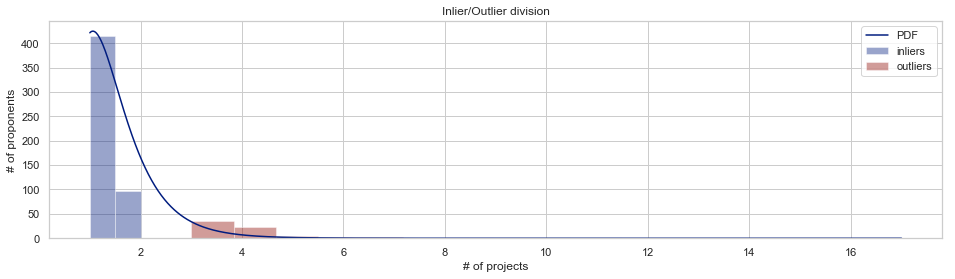

In [10]:
model = Lognormal()
model.fit(projects_train)
%time inlier_filter = model.predict(projects_test)

contamination_found = sum(~inlier_filter) / len(projects_test)
print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 1
inliers = projects_test[inlier_filter].values
bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

outliers = projects_test[~inlier_filter].values
bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)

x = np.linspace(min(proponent_projects), max(proponent_projects), 1000)
plt.plot(x,  bin_size * len(projects_test) * model.model.pdf(x), label='PDF')

plt.legend(frameon=True)
plt.ylabel('# of proponents')
plt.xlabel('# of projects')
plt.title('Inlier/Outlier division');

### Análise LOF

In [11]:
from sklearn.neighbors import LocalOutlierFactor

class LOF:
    def __init__(self, contamination=0.1):
        '''Unsupervised Outlier Detection by fitting data in a Local Outlier Factor
        model.

        The class sklearn.neighbors.LocalOutlierFactor has two operation modes:
            1. Outlier Detection: given a set of samples, return which samples are
               inliers and which ones are outliers.
            2. Novelty Detection: train model with inliers and predict if a new
               sample is inlier or outlier.
        
        This class uses the "Outlier Detection" to separate inliers and outliers
        from the training data, and then uses the "Novelty Detection" to train the
        model itself. At the prediction, the "Novelty Detection" separates the
        inliers and outliers.

        Parameters
        ----------
        contamination : float in (0., 0.5), optional (default=0.1)
            The amount of contamination of the data set, i.e. the proportion
            of outliers in the data set. When fitting this is used to define the
            threshold on the decision function.
        '''
        self.contamination = contamination

    def fit(self, X):
        '''Fit the LOF model, i.e. use the "Outlier Detection" to separate inliers
        and outliers from the training data and then uses the "Novelty Detection"
        to train the model itself.

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            Training data.

        Returns
        -------
        self : object
        '''
        # Transform data into a 2D array
        X = self._1Dto2D(X)

        # Get inliers of the training set with LOF Outlier Detection
        lof_OD = LocalOutlierFactor(contamination=self.contamination)
        y = lof_OD.fit_predict(X)
        X = X[y == 1, :]

        # Train model with LOF Novelty Detection, using train set inliers
        # Parameter 'contamination' does not matter at this point
        self.model = LocalOutlierFactor(novelty=True, contamination=0.5)
        self.model = self.model.fit(X)
        return self
    
    def predict(self, X):
        '''Predict the labels (True inlier, False outlier) of X according to
        the Local Outlier Factor model.

        This method allows to generalize prediction to *new observations* (not
        in the training set).

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            The query sample or samples to compute the LOF estimation
            w.r.t. to the training samples.

        Returns
        -------
        is_inlier : array, shape (n_samples,)
            Returns False for anomalies/outliers and True for inliers.
        '''
        X = self._1Dto2D(X)
        is_inlier = (self.model.predict(X) == 1)
        return is_inlier
    
    def _1Dto2D(self, X):
        '''Given a pd.Series, return a "2D" np.Array with zeros in one dimension.
        
        Parameters
        ----------
        X : pd.Series, shape (n_samples,)
        
        Returns
        -------
        X : bidimensional ndarray, shape (n_samples, 2)
        '''
        shape = (len(X),1)
        return np.hstack([np.array(X.tolist()).reshape(shape), np.zeros(shape)])

CPU times: user 4.38 ms, sys: 186 µs, total: 4.57 ms
Wall time: 4.63 ms
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 1.03%


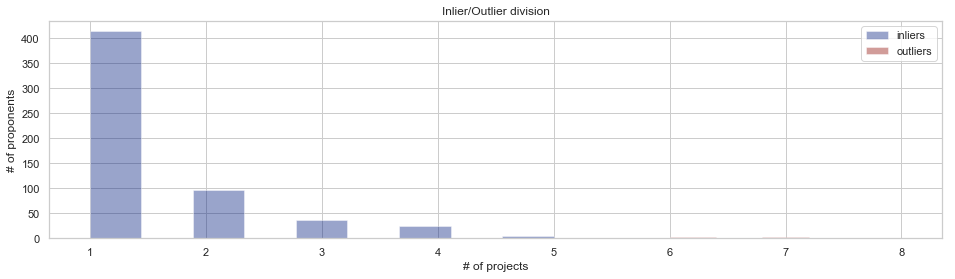

In [12]:
model = LOF()
model.fit(projects_train)
%time inlier_filter = model.predict(projects_test)

contamination_found = sum(~inlier_filter) / len(projects_test)
print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 0.5
inliers = projects_test[inlier_filter].values
bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

outliers = projects_test[~inlier_filter].values
bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)

plt.legend(frameon=True)
plt.ylabel('# of proponents')
plt.xlabel('# of projects')
plt.title('Inlier/Outlier division');

### Avaliando a contaminação para cada um dos métodos

Nesta seção, os métodos Gaussiano e LOF são aplicados a 100 escolhas diferentes de conjuntos de treino/teste. Ao final, o desempenho de cada método é avaliado.

In [13]:
percentuals = {
    'gauss': [],
    'lognorm': [],
    'lof': []
}

gauss = Gaussian()
lognorm = Lognormal()
lof = LOF()

for i in range(100):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(proponent_projects, test_size=0.3)
    
    # GAUSSIAN
    inlier_filter = (gauss.fit(projects_train).predict(projects_test))
    contamination_found = sum(~inlier_filter) / len(projects_test)
    percentuals['gauss'].append(100 * contamination_found)
    
    # LOGNORMAL
    inlier_filter = (lognorm.fit(projects_train).predict(projects_test))
    contamination_found = sum(~inlier_filter) / len(projects_test)
    percentuals['lognorm'].append(100 * contamination_found)
    
    # LOF
    inlier_filter = (lof.fit(projects_train).predict(projects_test))
    contamination_found = sum(~inlier_filter) / len(projects_test)
    percentuals['lof'].append(100 * contamination_found)

Média gauss: 5.06%
Média lognorm: 11.64%
Média lof: 1.97%


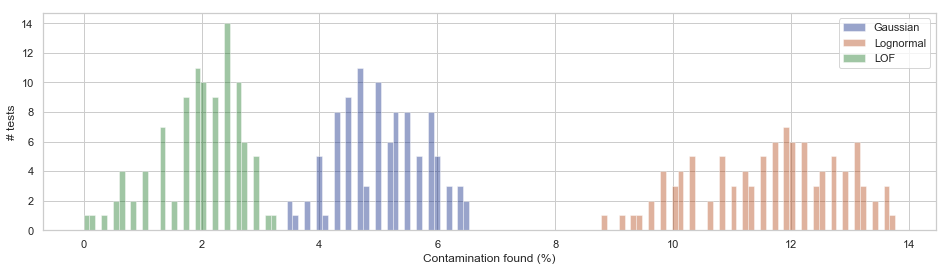

In [14]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 0.1
results = percentuals['gauss']
print('Média gauss: %.2lf%%' % np.mean(results))
bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
sns.distplot(results, label='Gaussian', kde=False, bins=bins)

results = percentuals['lognorm']
print('Média lognorm: %.2lf%%' % np.mean(results))
bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
sns.distplot(results, label='Lognormal', kde=False, bins=bins)

results = percentuals['lof']
print('Média lof: %.2lf%%' % np.mean(results))
bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
sns.distplot(results, label='LOF', kde=False, bins=bins)

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)

#### Conclusões

Primeiramente, é importante deixar claro que os projetos que foram considerados nessa análise, foram projetos com pelo menos um item comprovado.

Este dataset tem uma distribuição de se aproxima a Log-normal, e, além disso, o percentual de contaminação encontrada pelo Log-normal se mostrou mais próximo do valor esperado que os demais métodos.

Apesar de o LOF ser um algoritmo bom para detecção de outliers, ele não aparenta ser a melhor alternativa para o contexto em que esta métrica está inserida,pois ele detecta um percentual inferior ao desejado de outliers.

A gaussiana aparenta ser melhor que o LOF, porém é uma distribuição menos precisa que o Log-normal. 

Ao avaliar estes dois aspectos, percebe-se que essa distribuição Log-normal é a mais recomendada para a métrica de número de projetos por proponente.